In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Flatten

In [2]:
bit_data = pd.read_csv("bitstampUSD_1-min_data_2012-01-01_to_2020-09-14.csv")
bit_data.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
bit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4572257 entries, 0 to 4572256
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 279.1 MB


In [4]:
bit_data["date"] = pd.to_datetime(bit_data["Timestamp"],unit="s").dt.date
group = bit_data.groupby("date")
data = group["Close"].mean()

In [5]:
bit_data.dropna().head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,date
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31
478,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,2011-12-31
547,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411,2011-12-31
548,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,2011-12-31
1224,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,2012-01-01


In [6]:
bit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4572257 entries, 0 to 4572256
Data columns (total 9 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
 8   date               object 
dtypes: float64(7), int64(1), object(1)
memory usage: 314.0+ MB


In [7]:
data.shape

(3178,)

In [8]:
close_train = data.iloc[:len(data)-60]
close_test = data.iloc[len(close_train):]

In [9]:
close_train = np.array(close_train)
close_train = close_train.reshape(close_train.shape[0],1)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
close_scaled = scaler.fit_transform(close_train)

In [10]:
print(len(close_train))
print(len(close_test))

3118
60


In [11]:
timestep = 60
x_train = []
y_train = []
for i in range(timestep, close_scaled.shape[0]):
    x_train.append(close_scaled[i-timestep:i,0])
    y_train.append(close_scaled[i,0])

In [12]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],1) # reshaped for RNN
print("x-train shape = ", x_train.shape)
print("y-train shape = ", y_train.shape)

x-train shape =  (3058, 60, 1)
y-train shape =  (3058,)


In [13]:
model = Sequential()
model.add(Dense(56, input_shape=(x_train.shape[1], 1), activation ='relu'))
model.add(Dense(32, activation ='relu'))
model.add(Flatten())
model.add(Dense(1))

model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(x_train, y_train, epochs=50, batch_size=64)

Train on 3058 samples
Epoch 1/50
3058/3058 [==============================] - 1s 310us/sample - loss: 0.0036
Epoch 2/50
3058/3058 [==============================] - 0s 50us/sample - loss: 0.0012
Epoch 3/50
3058/3058 [==============================] - 0s 50us/sample - loss: 7.9286e-04
Epoch 4/50
3058/3058 [==============================] - 0s 56us/sample - loss: 6.2202e-04
Epoch 5/50
3058/3058 [==============================] - 0s 50us/sample - loss: 5.2634e-04
Epoch 6/50
3058/3058 [==============================] - 0s 45us/sample - loss: 4.5344e-04
Epoch 7/50
3058/3058 [==============================] - 0s 45us/sample - loss: 3.9984e-04
Epoch 8/50
3058/3058 [==============================] - 0s 49us/sample - loss: 4.1267e-04
Epoch 9/50
3058/3058 [==============================] - 0s 53us/sample - loss: 3.5869e-04
Epoch 10/50
3058/3058 [==============================] - 0s 45us/sample - loss: 3.2101e-04
Epoch 11/50
3058/3058 [==============================] - 0s 48us/sample - loss: 4.58

In [14]:
inputs = data[len(data)-len(close_test)-timestep:]
inputs = inputs.values.reshape(-1,1)
inputs = scaler.transform(inputs)

In [15]:
x_test = []
for i in range(timestep, inputs.shape[0]):
    x_test.append(inputs[i-timestep:i,0])

In [16]:
x_test = np.array(x_test)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1],1) # reshaped for RNN

In [17]:
predicted_data = model.predict(x_test)
predicted_data = scaler.inverse_transform(predicted_data)

In [18]:
data_test = np.array(close_test)
data_test = data_test.reshape(len(data_test),1)

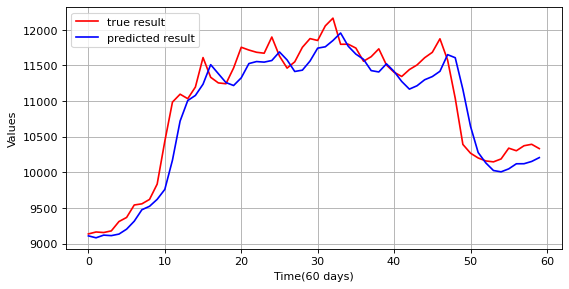

In [19]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data_test, color='r', label='true result')
plt.plot(predicted_data, color='b', label='predicted result')
plt.legend()
plt.xlabel("Time(60 days)")
plt.ylabel("Values")
plt.grid(True)
plt.show()